In [1]:
#pip install joypy

In [148]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import multiprocessing as mp
import queue
import shelve
import pandas as pd
import seaborn as sns
from joypy import joyplot
import scipy
from scipy import stats
from scipy.stats import t, f
from statsmodels.stats import multitest 

In [149]:
from queue_function import run_queue_experiment, vary_t_worker, vary_rho_worker, expected_waiting_time, \
    tib_deterministic, tib_hyp_exponential, tib_exponential
from util import initialize_parallel_rngs

In [150]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
    
plt.rc("font", family="serif")

### Helper functions

In [151]:

def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [152]:
def F_test(Samples_A, Samples_B):
    """ Calculates the F-test based on the data from two datasets.
        Returns:
            F-statistics (int)
            p=value (int)
    """
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - scipy.stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

In [153]:
def vary_rho(seed, capacity_server, t_length=1e5, n_server=1, steps=20, n_runs=20):
    manager = mp.Manager()
    results = manager.list()
    rhos = np.linspace(0.5, 0.95, steps)
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)

    work_queue = mp.Queue()
    
    for i in range(n_runs):
        results.append(manager.list())
        for rho in rhos:
            work_queue.put((rho, i))
    
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_rho_worker, args=(
            work_queue, results, rngs[i], t_length, capacity_server, n_server
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], rhos

In [154]:
def vary_t(min_exp, max_exp, seed, arrival_rate, capacity_server, tib_func = tib_exponential, n_server=1, steps=10, n_runs=5,
           queueing_discipline="FIFO"):
    manager = mp.Manager()
    results = manager.list()
    t_range = np.logspace(min_exp, max_exp, num=((max_exp - min_exp) + 1)*steps, dtype=int)
    
    work_queue = mp.Queue()
    for i in range(n_runs):
        results.append(manager.list())
        for t in t_range:
            work_queue.put((t, i))
    
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_t_worker, args=(
            work_queue, results, rngs[i], arrival_rate, capacity_server, n_server, queueing_discipline, tib_func
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], t_range

#### Varying t value

In [166]:
if False: 
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=8539, arrival_rate=0.9, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results_0.9"] = vary_t_results
    shelf["t_range"] = t_range
    shelf.close()

if False:
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=234234, arrival_rate=0.5, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results_0.5"] = vary_t_results
    shelf.close() 

if False:
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=3454535, arrival_rate=0.7, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results_0.7"] = vary_t_results
    shelf.close()

if False:
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=123123, arrival_rate=0.95, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results_0.95"] = vary_t_results
    shelf.close()     

In [167]:
shelf = shelve.open("Arrays/t_parameter")

Dict_t = {}
for i in ["0.5", "0.7", "0.9", "0.95"]:
    name = "vary_t_results_" + i 
    Dict_t[i] = shelf[name]

t_range = shelf["t_range"] 
shelf.close()

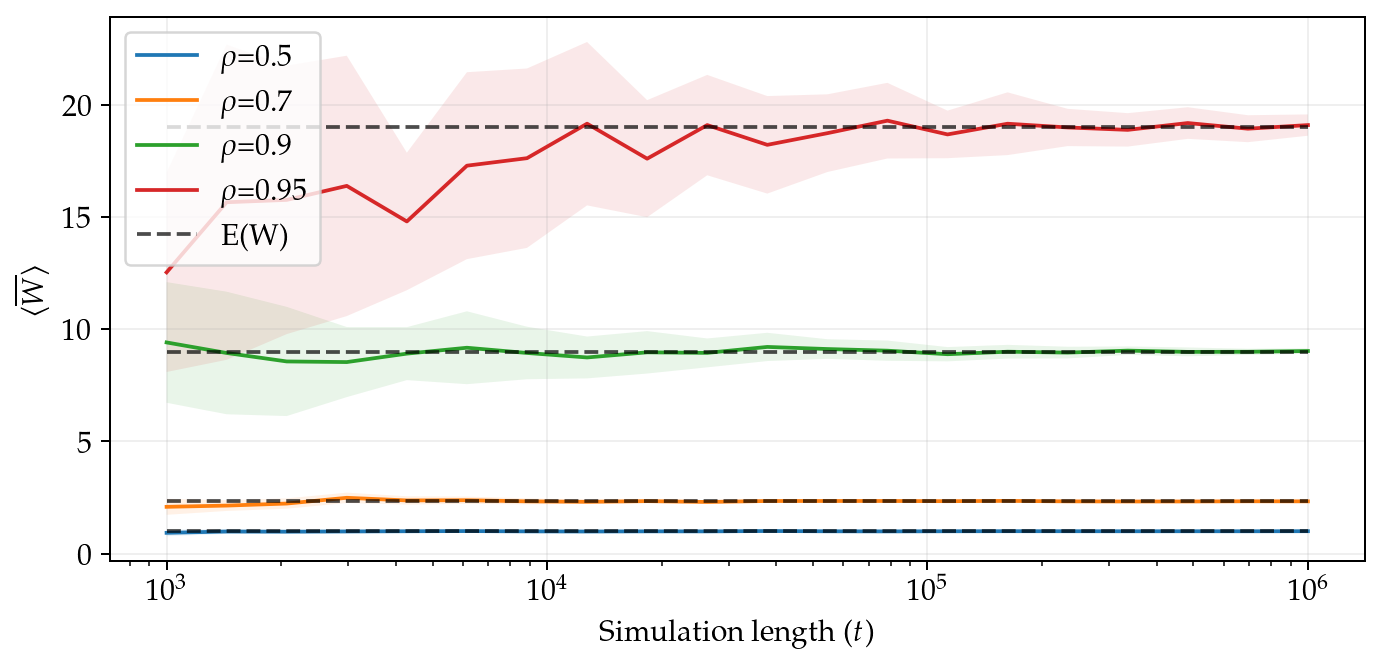

In [183]:
#Make longer and bigger (different rhos)
#And perhaps on a linear scale
fig = plt.figure(figsize=(9, 4))
E_Ws = []
for i in ["0.5", "0.7", "0.9", "0.95"]:
    vary_t_results = Dict_t[i]
    results = [list(t) for t in vary_t_results]
    results_means = np.mean(results, axis=0)
    E_W = expected_waiting_time(float(i), 1, 1)
    E_Ws.append(E_W)
    a = [sp_confidence_interval(samples) for samples in np.array(results).T]
    plt.plot(t_range, results_means, label="$\\rho$="+i)
    plt.fill_between(t_range, results_means - a, results_means + a, alpha=0.1)

plt.hlines(E_Ws, t_range[0], t_range[-1], linestyles="--", color = "black", label = "E(W)", zorder = 3, alpha = 0.7)
plt.xlabel("Simulation length ($t$)")
plt.xscale("log")
plt.ylabel("$\\langle\\overline{W}\\rangle$")
plt.legend()
plt.grid(alpha=0.2)
plt.savefig("figures/time_paramater_choice.pdf", bbox_inches="tight")
plt.show()

#### Varying rho values

In [58]:
if False:
    shelf = shelve.open("Arrays/rho_parameter")
    varying_rho_data = []
    rhos = None

    for i, n_server in enumerate((1, 2, 4)):
        run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e5, n_runs=50, n_server=n_server, steps = 50)
        #run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e2, n_runs=50, n_server=n_server, steps = 50)
        rhos = rhos_
        varying_rho_data.append(run_data)

    shelf["vary_rho_results"] = varying_rho_data
    shelf["rhos"] = rhos
    shelf.close()

In [142]:
shelf = shelve.open("Arrays/rho_parameter")
varying_rho_data = shelf["vary_rho_results"]
rhos = shelf["rhos"] 
shelf.close()

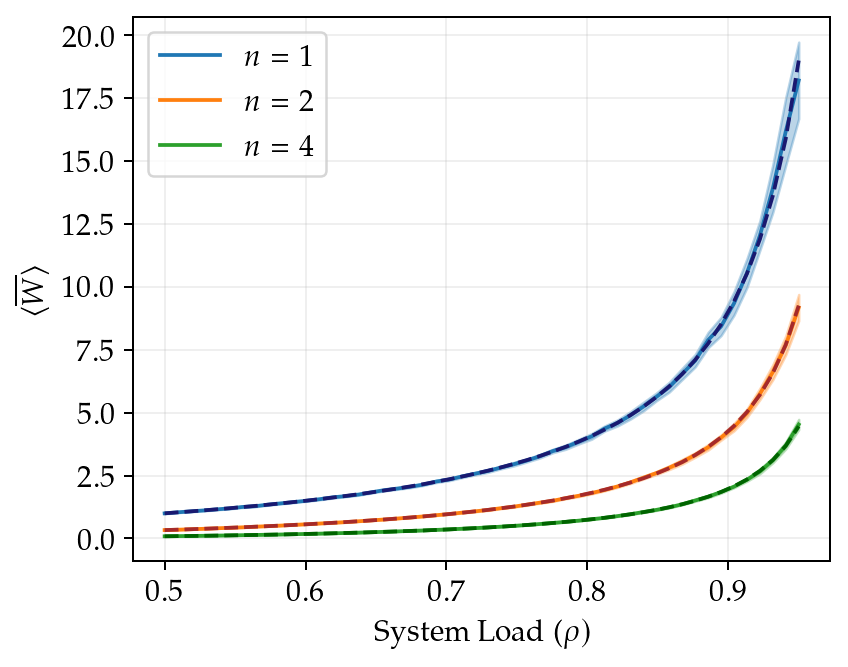

In [145]:
#Start at a later point
fig = plt.figure(figsize=(5, 4))

labels = ("$n = 1$", "$n = 2$", "$n = 4$")
colors = ("tab:blue", "tab:orange", "tab:green")
E_W_colors = ("midnightblue", "brown", "darkgreen")

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    run_data_mean = np.mean(run_data, axis=0)
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    run_data_std = np.std(run_data, axis=0, ddof=1)
    plt.plot(rhos, run_data_mean, label=labels[i], color=colors[i])
    plt.fill_between(rhos, run_data_mean - a, run_data_mean + a, alpha=0.3, color=colors[i])
    
    E_Ws = [expected_waiting_time(rho*n_server, 1, n_server) for rho in rhos]
    plt.plot(rhos, E_Ws, "--", color=E_W_colors[i])
    #plt.yscale("log")
    plt.grid(alpha=0.2)

plt.xlabel("System Load ($\\rho)$")
plt.ylabel("$\\langle\\overline{W}\\rangle$")
plt.legend()
plt.savefig("figures/varying_rho_1_2_4.pdf", bbox_inches="tight")
plt.show()

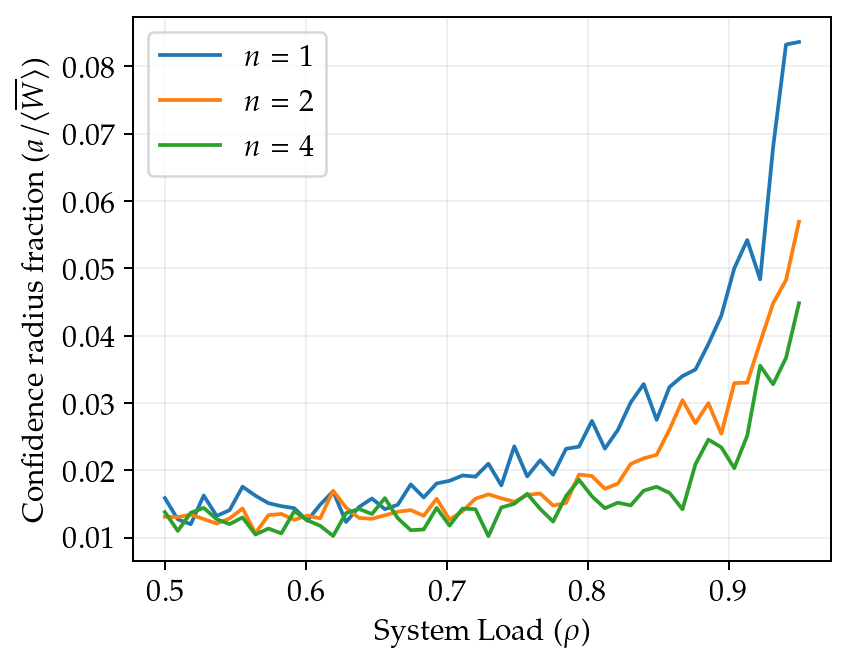

In [147]:
fig = plt.figure(figsize=(5, 4))

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    plt.plot(rhos, a/np.mean(run_data, axis=0), label=labels[i], color=colors[i])
    plt.grid(alpha=0.2)

plt.xlabel("System Load ($\\rho$)")
plt.ylabel("Confidence radius fraction ($a/\\langle\\overline{W}\\rangle$)")
plt.legend()
plt.savefig("figures/confidence_radius_fraction_rhos.pdf", bbox_inches="tight")
plt.show()

#### Comparing M/M/1 and M/M/n

In [112]:
   
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_n1, _ = vary_t(min_exp=5, max_exp=5, seed=89253, n_server=1,
                              arrival_rate=0.9*1, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n1_0.90"] = sum(stats_data_n1, [])
    stats_data_n2, _ = vary_t(min_exp=5, max_exp=5, seed=11010135, n_server=2,
                              arrival_rate=0.9*2, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n2_0.90"] = sum(stats_data_n2, [])
    stats_data_n4, t_range = vary_t(min_exp=5, max_exp=5, seed=885302, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n4_0.90"] = sum(stats_data_n4, [])
    
    shelf["t_range"] = t_range
    shelf.close()

In [10]:
shelf = shelve.open("Arrays/stats_varying_n")
stats_data = [shelf["stats_data_n1_0.90"], shelf["stats_data_n2_0.90"],shelf["stats_data_n4_0.90"]]
t_range = shelf["t_range"] 
shelf.close()

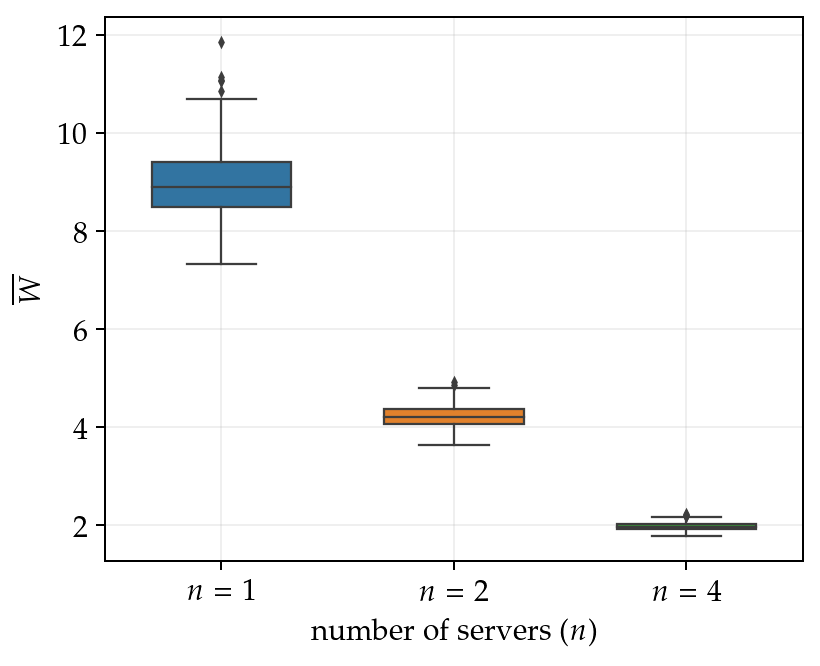

In [138]:
fig = plt.figure(figsize=(5, 4))


stats_data_n1, stats_data_n2, stats_data_n4 = stats_data 
values_n1 = np.array(stats_data_n1)
values_n2 = np.array(stats_data_n2)
values_n4 = np.array(stats_data_n4)
data_n1 = np.array([np.repeat("$n = 1$", len(values_n1)), values_n1])
data_n2 = np.array([np.repeat("$n = 2$", len(values_n2)), values_n2])
data_n3 = np.array([np.repeat("$n = 4$", len(values_n4)), values_n4])
Data = np.concatenate([data_n1, data_n2, data_n3], axis = 1)

df = pd.DataFrame(Data.T, columns = ["n", "E(W)"])
df = df.astype({"E(W)": float})
ax = sns.boxplot(x="n", y="E(W)",  data=df, width = 0.6, zorder=3, linewidth=0.9, fliersize = 2)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.yscale("log")
plt.ylabel("$\\overline{W}$")
plt.xlabel("number of servers ($n$)")
plt.savefig("figures/box_plot_1_2_4_rho0.90.pdf", bbox_inches="tight")
plt.show()

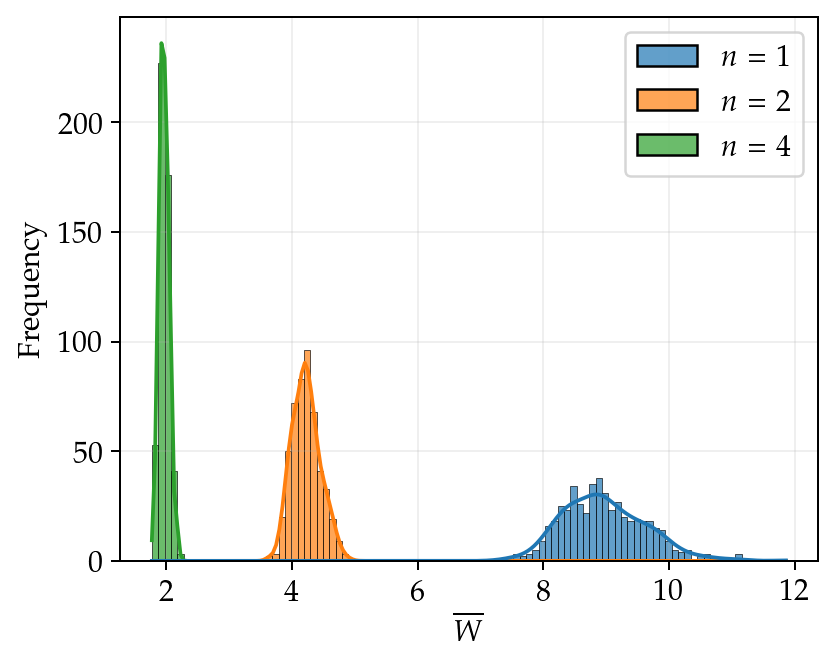

In [119]:
plt.figure(figsize = (5,4))
g = sns.histplot(data = df, hue="n", x="E(W)", alpha=0.7, kde = True, bins = 100)
g.legend_.set_title(None)
plt.grid(alpha=0.2)
plt.xlabel("$\\overline{W}$")
plt.ylabel("Frequency")
#plt.title("$\\rho = 0.90$")
plt.savefig("figures/dist_plot_1_2_4_rho0.90.pdf", bbox_inches="tight")
plt.show()

In [12]:
print("\nMeans")
print("n1: ", np.mean(stats_data_n1))
print("n2: ", np.mean(stats_data_n2))
print("n4: ", np.mean(stats_data_n4))

print("\nExpected waiting times")
print("n1: ", expected_waiting_time(0.9*1, 1, 1))
print("n2: ", expected_waiting_time(0.9*2, 1, 2))
print("n4: ", expected_waiting_time(0.9*4, 1, 4))

print("\nConfidence radius")
print("n1: ", sp_confidence_interval(stats_data_n1))
print("n2: ", sp_confidence_interval(stats_data_n2))
print("n4: ", sp_confidence_interval(stats_data_n4))

print("\nVariance")
print("n1: ", np.var(stats_data_n1, ddof = 1))
print("n2: ", np.var(stats_data_n2, ddof = 1))
print("n4: ", np.var(stats_data_n4, ddof = 1))



Means
n1:  8.976122708760661
n2:  4.22699285531563
n4:  1.9699905692722859

Expected waiting times
n1:  9.000000000000002
n2:  4.2631578947368425
n4:  1.9693831607384067

Confidence radius
n1:  0.11660509639521521
n2:  0.03929048068578567
n4:  0.01376496473845279

Variance
n1:  0.4402907826595407
n2:  0.04998954838426233
n4:  0.006135567460499043


#### Comparing FIFO and SPTF

In [69]:
if False:
    shelf = shelve.open("Arrays/stats_sptf_fifo")

    sptf_stats = sum(vary_t(min_exp=5, max_exp=5, seed=1239130, n_server=1, n_runs=500,
                   arrival_rate=0.9, capacity_server=1, steps=1, queueing_discipline="SPTF")[0], [])
    shelf["sptf_stats"] = sptf_stats
    shelf.close()


In [131]:
shelf = shelve.open("Arrays/stats_sptf_fifo")
sptf_stats = shelf["sptf_stats"] 
shelf.close()

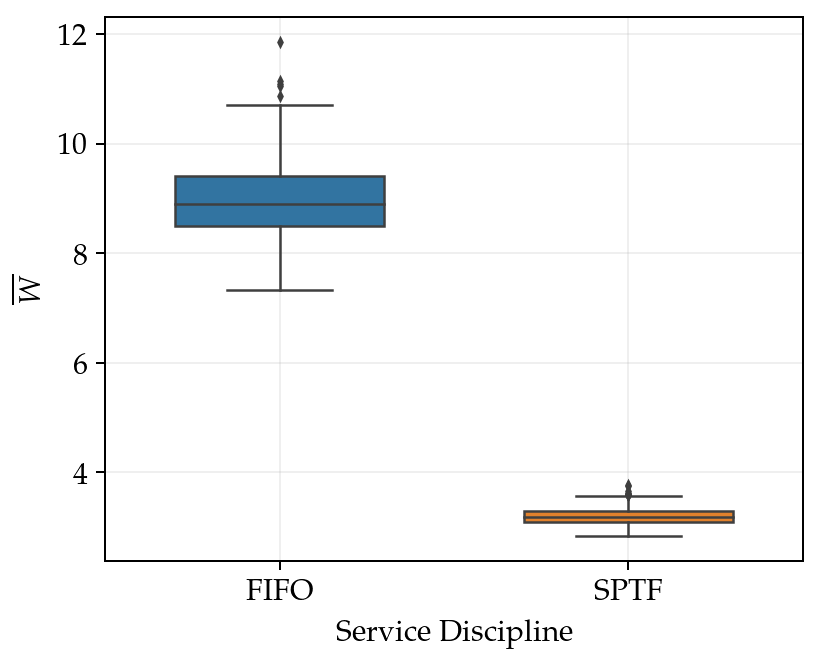

In [135]:
plt.figure(figsize = (5, 4))
values_fifo = np.array(stats_data[0])
values_sptf = np.array(sptf_stats)
data_fifo = np.array([np.repeat("FIFO", len(values_fifo)), values_fifo])
data_sptf = np.array([np.repeat("SPTF", len(values_sptf)), values_sptf])
data_fifo_sptf = np.concatenate([data_fifo, data_sptf], axis = 1)

df_fifo_sptf = pd.DataFrame(data_fifo_sptf.T, columns = ["Service Discipline", "W"])
df_fifo_sptf = df_fifo_sptf.astype({"W": float})
ax = sns.boxplot(x="Service Discipline", y="W",  data=df_fifo_sptf, width = 0.6, zorder=3, linewidth=1, fliersize = 2)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.title(f"rho = {rho}")
#plt.yscale("log")
plt.ylabel("$\\overline{W}$")
plt.xlabel("Service Discipline")
plt.savefig("figures/fifo_vs_sptf_boxplot.pdf", bbox_inches="tight")
plt.show()

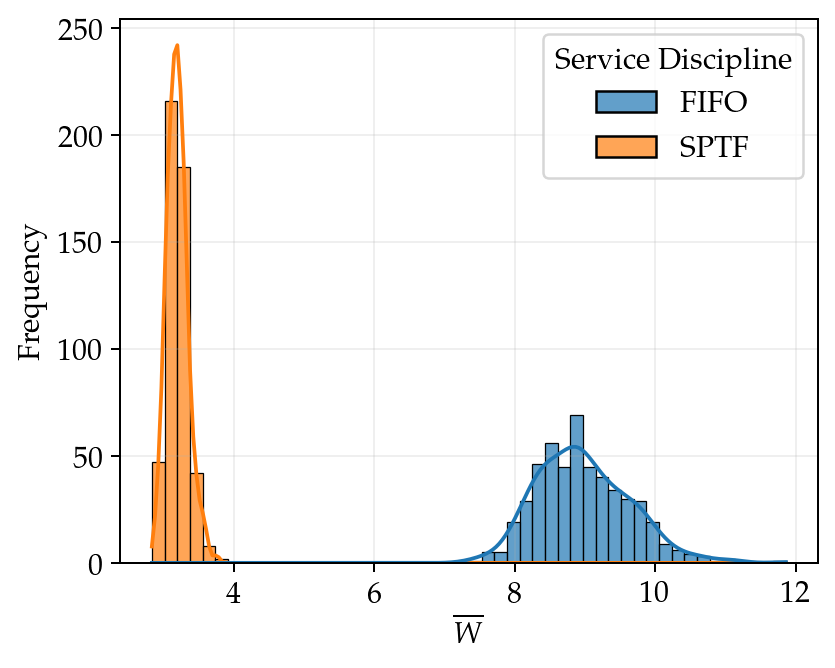

In [133]:
plt.figure(figsize = (5, 4))
sns.histplot(data = df_fifo_sptf, hue="Service Discipline", x="W", alpha=0.7, kde = True, bins=50)
plt.grid(alpha=0.2)
plt.xlabel("$\\overline{W}$")
plt.ylabel("Frequency")
plt.savefig("figures/fifo_vs_sptf_dist.pdf", bbox_inches="tight")
plt.show()

In [47]:
print("\nMeans")
print("FIFO: ", np.mean(stats_data_n1))
print("SPTF: ", np.mean(sptf_stats))

print("\nExpected waiting times")
print("FIFO: ", expected_waiting_time(0.9*1, 1, 1))
print("SPTF: ", )


print("\nConfidence radius")
print("FIFO: ", sp_confidence_interval(stats_data_n1))
print("SPTF: ", sp_confidence_interval(sptf_stats))

print("\nVariance")
print("FIFO: ", np.var(stats_data_n1, ddof = 1))
print("SPTF: ", np.var(sptf_stats, ddof = 1))



Means
FIFO:  8.976122708760661
SPTF:  3.1957186419972965

Expected waiting times
FIFO:  9.000000000000002
SPTF: 

Confidence radius
FIFO:  0.11660509639521521
SPTF:  0.026278887899969128

Variance
FIFO:  0.4402907826595407
SPTF:  0.022362404234287023


#### Different service distributions

In [73]:
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_md1, _ = vary_t(min_exp=5, max_exp=5, seed=456894, n_server=1,
                              arrival_rate=0.9*1, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md1"] = sum(stats_data_md1, [])
    stats_data_md2, _ = vary_t(min_exp=5, max_exp=5, seed=929834, n_server=2,
                              arrival_rate=0.9*2, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md2"] = sum(stats_data_md2, [])
    stats_data_md4, t_range = vary_t(min_exp=5, max_exp=5, seed=123, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=1, steps=1, n_runs=500, tib_func=tib_deterministic)
    shelf["stats_data_md4"] = sum(stats_data_md4, [])
    
    shelf["t_range"] = t_range
    shelf.close()
    
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_mh1, _ = vary_t(min_exp=5, max_exp=5, seed=456894, n_server=1,
                              arrival_rate=0.9*1, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh1"] = sum(stats_data_mh1, [])
    stats_data_mh2, _ = vary_t(min_exp=5, max_exp=5, seed=34345, n_server=2,
                              arrival_rate=0.9*2, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh2"] = sum(stats_data_mh2, [])
    stats_data_mh4, t_range = vary_t(min_exp=5, max_exp=5, seed=23423, n_server=4,
                                    arrival_rate=0.9*4, capacity_server=0.8, steps=1, n_runs=500, tib_func=tib_hyp_exponential)
    shelf["stats_data_mh4"] = sum(stats_data_mh4, [])
    
    shelf["t_range"] = t_range
    shelf.close()

In [13]:
shelf = shelve.open("Arrays/stats_varying_n")
stats_data_dict = {}

stats_data_dict["mm1"] =  shelf["stats_data_n1_0.90"]
stats_data_dict["mm2"] =  shelf["stats_data_n2_0.90"]
stats_data_dict["mm4"] =  shelf["stats_data_n4_0.90"]

stats_data_dict["md1"] =  shelf["stats_data_md1"]
stats_data_dict["md2"] =  shelf["stats_data_md2"]
stats_data_dict["md4"] =  shelf["stats_data_md4"]

stats_data_dict["mh1"] =  shelf["stats_data_mh1"]
stats_data_dict["mh2"] =  shelf["stats_data_mh2"]
stats_data_dict["mh4"] =  shelf["stats_data_mh4"]
t_range = shelf["t_range"] 

shelf.close()

(3, 4500)


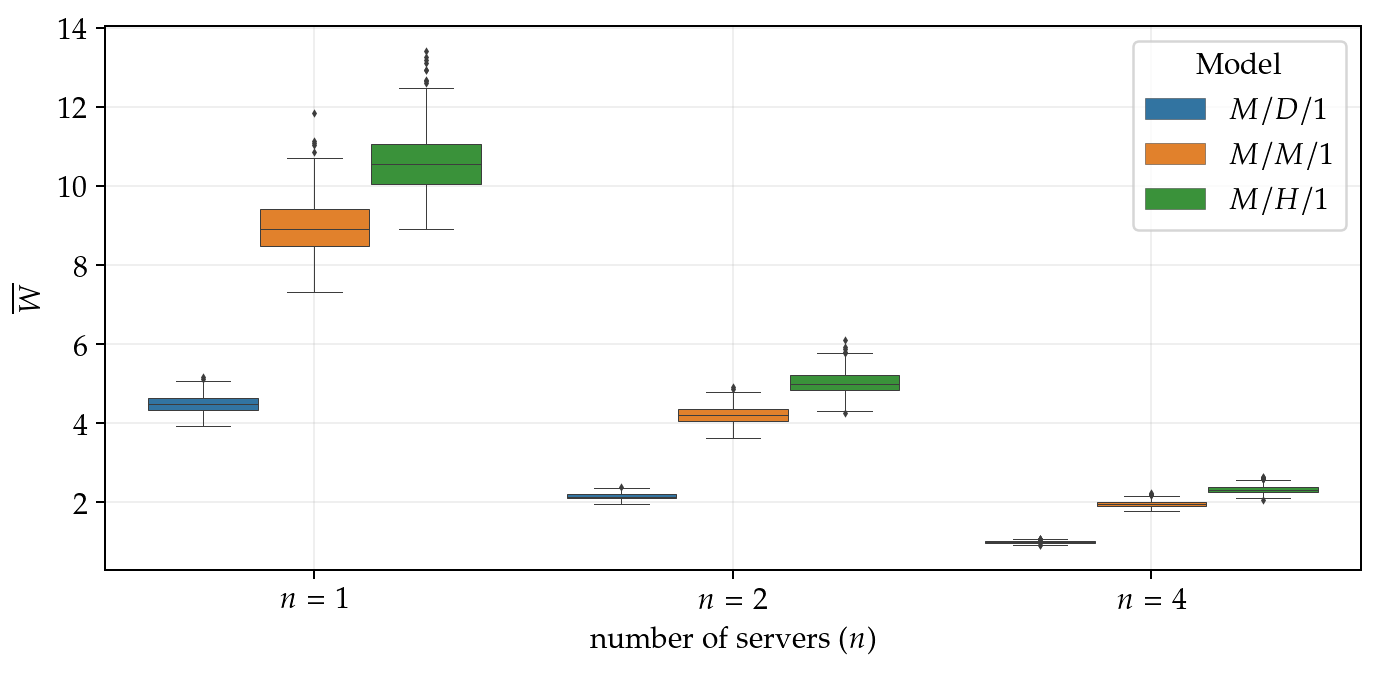

In [128]:
fig = plt.figure(figsize=(9, 4))

MM1 = np.array(stats_data_dict["mm1"])
MM2 = np.array(stats_data_dict["mm2"])
MM4 = np.array(stats_data_dict["mm4"])

MD1 = np.array(stats_data_dict["md1"])
MD2 = np.array(stats_data_dict["md2"])
MD4 = np.array(stats_data_dict["md4"])

MH1 = np.array(stats_data_dict["mh1"])
MH2 = np.array(stats_data_dict["mh2"])
MH4 = np.array(stats_data_dict["mh4"])

data_n1_D = np.array([np.repeat("$n = 1$", len(MD1)), MD1])
data_n2_D = np.array([np.repeat("$n = 2$", len(MD2)), MD2])
data_n3_D = np.array([np.repeat("$n = 4$", len(MD4)), MD4])
Data_D = np.concatenate([data_n1_D, data_n2_D, data_n3_D], axis = 1)
labels = np.array([np.repeat("$M/D/1$",  len(Data_D[0,:]))])
Data_D = np.concatenate((labels, Data_D), axis = 0)

data_n1_M = np.array([np.repeat("$n = 1$", len(MM1)), MM1])
data_n2_M = np.array([np.repeat("$n = 2$", len(MM2)), MM2])
data_n3_M = np.array([np.repeat("$n = 4$", len(MM4)), MM4])
Data_M = np.concatenate([data_n1_M, data_n2_M, data_n3_M], axis = 1)
labels = np.array([np.repeat("$M/M/1$",  len(Data_M[0,:]))])
Data_M = np.concatenate((labels, Data_M), axis = 0)

data_n1_H = np.array([np.repeat("$n = 1$", len(MH1)), MH1])
data_n2_H = np.array([np.repeat("$n = 2$", len(MH2)), MH2])
data_n3_H = np.array([np.repeat("$n = 4$", len(MH4)), MH4])
Data_H = np.concatenate([data_n1_H, data_n2_H, data_n3_H], axis = 1)
labels = np.array([np.repeat("$M/H/1$",  len(Data_H[0,:]))])
Data_H = np.concatenate((labels, Data_H), axis = 0)


Data = np.concatenate([Data_D, Data_M, Data_H], axis = 1)
print(Data.shape)

df = pd.DataFrame(Data.T, columns = ["Model", "n", "E(W)"])
df = df.astype({"E(W)": float})
ax = sns.boxplot(x="n", y="E(W)", hue = "Model",  data=df, width = 0.8, zorder=3, linewidth=0.4, fliersize = 1)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.yscale("log")
plt.ylabel("$\\overline{W}$")
plt.xlabel("number of servers ($n$)")
plt.savefig("figures/box_plot_Diff_distr.pdf", bbox_inches="tight")
plt.show()

<Figure size 1080x720 with 0 Axes>

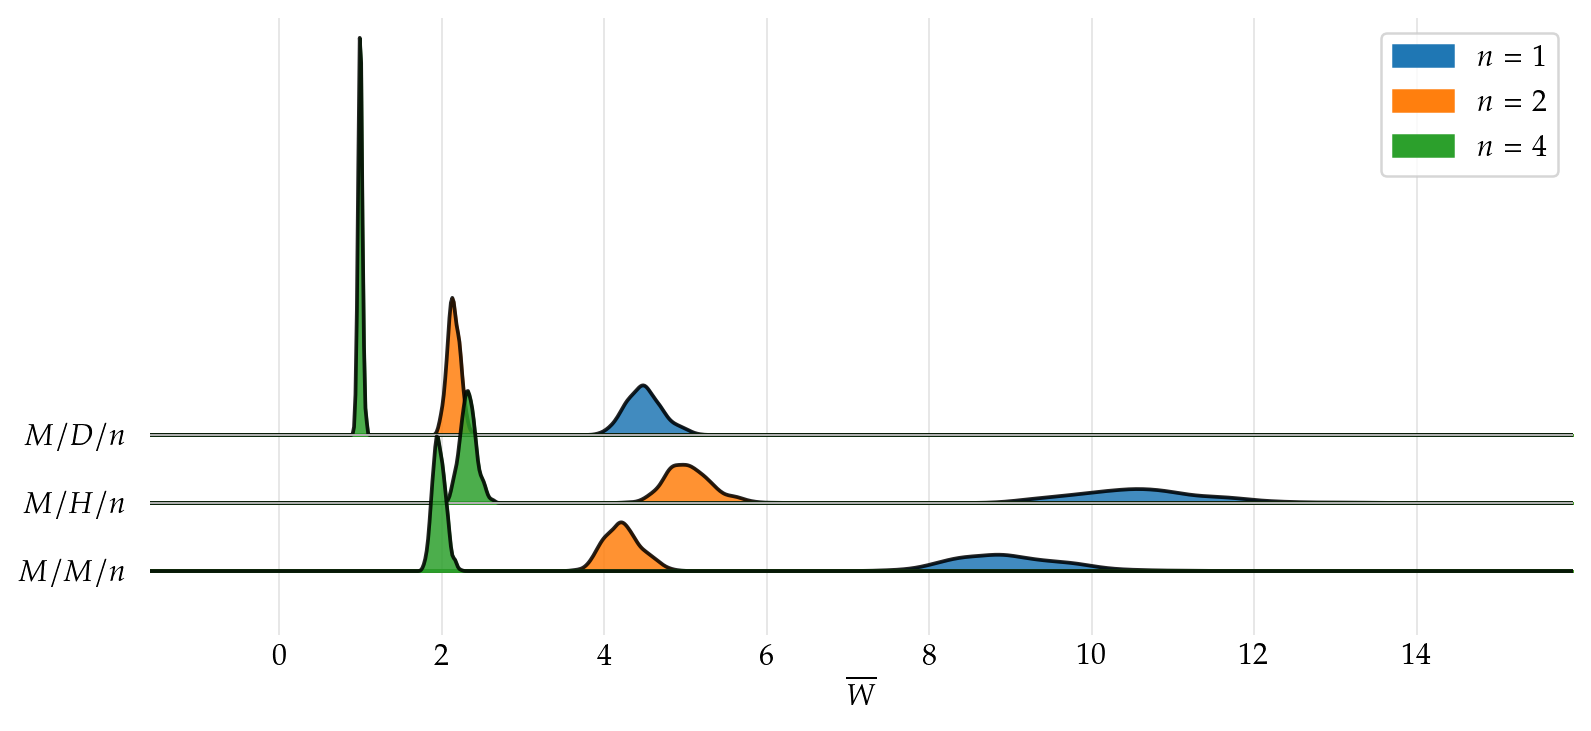

In [107]:

data_exp = np.array([np.repeat("$M/M/n$", len(stats_data_dict["mm1"])), stats_data_dict["mm1"], stats_data_dict["mm2"], stats_data_dict["mm4"]])
data_det = np.array([np.repeat("$M/D/n$", len(stats_data_dict["md1"])), stats_data_dict["md1"], stats_data_dict["md2"], stats_data_dict["md4"]])
data_hyp = np.array([np.repeat("$M/H/n$",  len(stats_data_dict["mh1"])), stats_data_dict["mh1"], stats_data_dict["mh2"], stats_data_dict["mh4"]])
Data = np.concatenate([data_exp, data_det, data_hyp], axis = 1)

df = pd.DataFrame(Data.T, columns = ["Service time Distribution", "$n=1$", "$n=2$", "$n=4$" ])
df = df.astype({"$n=1$": float})
df = df.astype({"$n=2$": float})
df = df.astype({"$n=4$": float})
#display(df)

plt.figure()
ax, fig = joyplot(
    data=df[["Service time Distribution", '$n=1$', '$n=2$', '$n=4$']], 
    by="Service time Distribution",
    column=['$n=1$', '$n=2$', '$n=4$'],
    color=["tab:blue", "tab:orange", "tab:green"],
    legend=True,
    alpha=0.85,
    overlap=2.75,
    figsize=(9, 4),
    #hist=True,
    #bins = 200,
    grid=True,
)
plt.grid(alpha=0.3)
plt.xlabel('$\\overline{W}$', fontsize=12)
plt.savefig("figures/joyplot_exp_det_hyp.pdf", bbox_inches="tight")
plt.show()

In [17]:
print("\n xxxxxxxxxxxxx M/M/1 xxxxxxxxxxxx")
print("\nMeans")
print("n1: ", np.mean(stats_data_n1))
print("n2: ", np.mean(stats_data_n2))
print("n4: ", np.mean(stats_data_n4))

print("\nExpected waiting times")
print("n1: ", expected_waiting_time(0.9*1, 1, 1))
print("n2: ", expected_waiting_time(0.9*2, 1, 2))
print("n4: ", expected_waiting_time(0.9*4, 1, 4))

print("\nConfidence radius")
print("n1: ", sp_confidence_interval(stats_data_n1))
print("n2: ", sp_confidence_interval(stats_data_n2))
print("n4: ", sp_confidence_interval(stats_data_n4))

print("\nVariance")
print("n1: ", np.var(stats_data_n1, ddof = 1))
print("n2: ", np.var(stats_data_n2, ddof = 1))
print("n4: ", np.var(stats_data_n4, ddof = 1))


print("\n xxxxxxxxxxxxx M/D/1 xxxxxxxxxxxx")
print("\nMeans")
print("n1: ", np.mean(stats_data_dict["md1"]))
print("n2: ", np.mean(stats_data_dict["md2"]))
print("n4: ", np.mean(stats_data_dict["md4"]))

print("\nExpected waiting times")
print("n1: ", expected_waiting_time(0.9*1, 1, 1)/2)
print("n2: ", expected_waiting_time(0.9*2, 1, 2)/2)
print("n4: ", expected_waiting_time(0.9*4, 1, 4)/2)

print("\nConfidence radius")
print("n1: ", sp_confidence_interval(stats_data_dict["md1"]))
print("n2: ", sp_confidence_interval(stats_data_dict["md2"]))
print("n4: ", sp_confidence_interval(stats_data_dict["md4"]))

print("\nVariance")
print("n1: ", np.var(stats_data_dict["md1"], ddof = 1))
print("n2: ", np.var(stats_data_dict["md2"], ddof = 1))
print("n4: ", np.var(stats_data_dict["md4"], ddof = 1))


print("\n xxxxxxxxxxxxx M/H/1 xxxxxxxxxxxx")
print("\nMeans")
print("n1: ", np.mean(stats_data_dict["mh1"]))
print("n2: ", np.mean(stats_data_dict["mh2"]))
print("n4: ", np.mean(stats_data_dict["mh4"]))


print("\nExpected waiting times")
print("n1: ")#, (expected_waiting_time(0.9*1, 0.8, 1)*0.75 + (expected_waiting_time(0.9*1, 0.8/5, 1)*0.25)))
print("n2: ")#, (expected_waiting_time(0.9*2, 0.8, 2)*0.75 + (expected_waiting_time(0.9*2, 0.8/5, 2)*0.25)))
print("n4: ")#, (expected_waiting_time(0.9*4, 0.8, 4)*0.75 + (expected_waiting_time(0.9*4, 0.8/5, 4)*0.25)))

print("\nConfidence radius")
print("n1: ", sp_confidence_interval(stats_data_dict["mh1"]))
print("n2: ", sp_confidence_interval(stats_data_dict["mh2"]))
print("n4: ", sp_confidence_interval(stats_data_dict["mh4"]))

print("\nVariance")
print("n1: ", np.var(stats_data_dict["mh1"], ddof = 1))
print("n2: ", np.var(stats_data_dict["mh2"], ddof = 1))
print("n4: ", np.var(stats_data_dict["mh4"], ddof = 1))


 xxxxxxxxxxxxx M/M/1 xxxxxxxxxxxx

Means
n1:  8.976122708760661
n2:  4.22699285531563
n4:  1.9699905692722859

Expected waiting times
n1:  9.000000000000002
n2:  4.2631578947368425
n4:  1.9693831607384067

Confidence radius
n1:  0.11660509639521521
n2:  0.03929048068578567
n4:  0.01376496473845279

Variance
n1:  0.4402907826595407
n2:  0.04998954838426233
n4:  0.006135567460499043

 xxxxxxxxxxxxx M/D/1 xxxxxxxxxxxx

Means
n1:  4.492310310595967
n2:  2.1505122180594083
n4:  0.9995445038186471

Expected waiting times
n1:  4.500000000000001
n2:  2.1315789473684212
n4:  0.9846915803692033

Confidence radius
n1:  0.039035855950070086
n2:  0.013534490237042895
n4:  0.004675373634844049

Variance
n1:  0.04934372623558971
n2:  0.005931825073549738
n4:  0.0007078433821177851

 xxxxxxxxxxxxx M/H/1 xxxxxxxxxxxx

Means
n1:  10.61508292702639
n2:  5.04103769734535
n4:  2.328610114473649

Expected waiting times
n1: 
n2: 
n4: 

Confidence radius
n1:  0.14076966032488514
n2:  0.04897205478949829
n4: 

#### Statistical Tests

In [28]:
alpha = 0.05


statistic_1F, p_value_1F = F_test(stats_data_n1, stats_data_n2)
statistic_2F, p_value_2F = F_test(stats_data_n2, stats_data_n4)
statistic_3F, p_value_3F = F_test(stats_data_n1, stats_data_n4)

#F tests Q2
statistic_4F, p_value_4F = F_test(stats_data_n1, sptf_stats)

#F tests Q3
statistic_5F, p_value_5F = F_test(stats_data_dict["mm1"], stats_data_dict["md1"])
statistic_6F, p_value_6F = F_test(stats_data_dict["mm1"], stats_data_dict["mh1"])
statistic_7F, p_value_7F = F_test(stats_data_dict["md1"], stats_data_dict["mh1"])

statistic_8F, p_value_8F = F_test(stats_data_dict["mm2"], stats_data_dict["md2"])
statistic_9F, p_value_9F = F_test(stats_data_dict["mm2"], stats_data_dict["mh2"])
statistic_10F, p_value_10F = F_test(stats_data_dict["md2"], stats_data_dict["mh2"])

statistic_11F, p_value_11F = F_test(stats_data_dict["mm4"], stats_data_dict["md4"])
statistic_12F, p_value_12F = F_test(stats_data_dict["mm4"], stats_data_dict["mh4"])
statistic_13F, p_value_13F = F_test(stats_data_dict["md4"], stats_data_dict["mh4"])




reject_a, pvals_corrected_a, alphacSidak_a, alphacBonf_a = multitest.multipletests(pvals = [eval(f"p_value_{i}F") for i in range(1, 14)], alpha = alpha, method = "bonferroni")
print(pvals_corrected_a)
print(reject_a)


#Welch tests Q1
statistic_1W, p_value_1W = stats.ttest_ind(stats_data_n1, stats_data_n2, equal_var = False)
statistic_2W, p_value_2W = stats.ttest_ind(stats_data_n2, stats_data_n4, equal_var = False)
statistic_3W, p_value_3W = stats.ttest_ind(stats_data_n1, stats_data_n4, equal_var = False)

#Welch tests Q2
statistic_4W, p_value_4W= stats.ttest_ind(stats_data_n1, sptf_stats)

#Welch tests Q3
statistic_5W, p_value_5W = stats.ttest_ind(stats_data_dict["mm1"], stats_data_dict["md1"], equal_var = False)
statistic_6W, p_value_6W = stats.ttest_ind(stats_data_dict["mm1"], stats_data_dict["mh1"], equal_var = False)
statistic_7W, p_value_7W = stats.ttest_ind(stats_data_dict["md1"], stats_data_dict["mh1"], equal_var = False)

statistic_8W, p_value_8W = stats.ttest_ind(stats_data_dict["mm2"], stats_data_dict["md2"], equal_var = False)
statistic_9W, p_value_9W = stats.ttest_ind(stats_data_dict["mm2"], stats_data_dict["mh2"], equal_var = False)
statistic_10W, p_value_10W = stats.ttest_ind(stats_data_dict["md2"], stats_data_dict["mh2"], equal_var = False)

statistic_11W, p_value_11W = stats.ttest_ind(stats_data_dict["mm4"], stats_data_dict["md4"], equal_var = False)
statistic_12W, p_value_12W = stats.ttest_ind(stats_data_dict["mm4"], stats_data_dict["mh4"], equal_var = False)
statistic_13W, p_value_13W = stats.ttest_ind(stats_data_dict["md4"], stats_data_dict["mh4"], equal_var = False)

reject_a_W, pvals_corrected_a_W, alphacSidak_a_W, alphacBonf_a_W = multitest.multipletests(pvals = [eval(f"p_value_{i}W") for i in range(1, 14)], alpha = alpha, method = "bonferroni")
print(pvals_corrected_a_W)
print(reject_a_W)



[1.44328993e-15 1.44328993e-15 1.44328993e-15 1.44328993e-15
 1.44328993e-15 1.79265230e-04 1.44328993e-15 1.44328993e-15
 6.28414565e-06 1.44328993e-15 1.44328993e-15 2.88617635e-06
 1.44328993e-15]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.42768349e-174 0.00000000e+000 0.00000000e+000
 3.16664953e-273 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
